<a href="https://colab.research.google.com/github/iskanor1/Handwritten/blob/main/Handwritten_Recognition_with_WEB_App.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
landlord_handwriting_recognition_path = kagglehub.dataset_download('landlord/handwriting-recognition')

print('Data source import complete.')


Data source import complete.


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
landlord_handwriting_recognition_path = kagglehub.dataset_download('landlord/handwriting-recognition')

print('Data source import complete.')


Data source import complete.


In [3]:
pip install scikit-learn==1.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 40.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [ ]:

# import kagglehub
# import shutil
# import os

# # Download latest version
# default_path = kagglehub.dataset_download("landlord/handwriting-recognition")

# print("Path to dataset files:", default_path)

# custom_path = "/content/"

# # Ensure the target directory exists
# os.makedirs(custom_path, exist_ok=True)

# # Move the dataset to the custom locationa
# shutil.move(default_path, custom_path)

# print("Dataset moved to:", custom_path)

Lets start by importing the necessary libraries. I'll be using Keras for building our CRNN model.

In [4]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

## Load and view data

In [5]:
traindf = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_train_v2.csv')
validdf = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_validation_v2.csv')

REDCUING THE DATA

In [6]:
num_rows_to_drop = int((len(traindf)* 0.97))
train = traindf.drop(traindf.index[0:num_rows_to_drop])
num_rows_to_drop = int((len(validdf)* 0.97))
valid = validdf.drop(validdf.index[0:num_rows_to_drop])

In [7]:
train.head()

,FILENAME,IDENTITY
321032,TRAIN_321033.jpg,NICOLAS
321033,TRAIN_321034.jpg,JADE
321034,TRAIN_321035.jpg,KPADE
321035,TRAIN_321036.jpg,BOIS
321036,TRAIN_321037.jpg,SARA


In [8]:
train.shape

(9929, 2)

In [9]:
valid.head()

,FILENAME,IDENTITY
40128,VALIDATION_40129.jpg,GRECET
40129,VALIDATION_40130.jpg,DE OLIVEIRA
40130,VALIDATION_40131.jpg,MARIE
40131,VALIDATION_40132.jpg,LUDIVINE
40132,VALIDATION_40133.jpg,MASSYL


In [10]:
valid.shape

(1242, 2)

# EXPLORATORY DATA ANALYSIS ORIGINAL DATA

In [11]:
train1 = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_train_v2.csv')

In [12]:
#lets find the categorialfeatures
list_1=list(train1.columns)
list_cate=[]
for i in list_1:
    if train1[i].dtype=='object':
        list_cate.append(i)

In [13]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for i in list_cate:
    train1[i]=le.fit_transform(train1[i])

In [14]:
train1

,FILENAME,IDENTITY
0,0,6790
1,1,88373
2,2,9411
3,3,54452
4,4,24870
...,...,...
330956,264052,59046
330957,264053,92820
330958,264054,23178
330959,264056,70125


In [15]:
X = train1.drop('FILENAME',axis=1)
y = train1['FILENAME']

HISTOGRAM

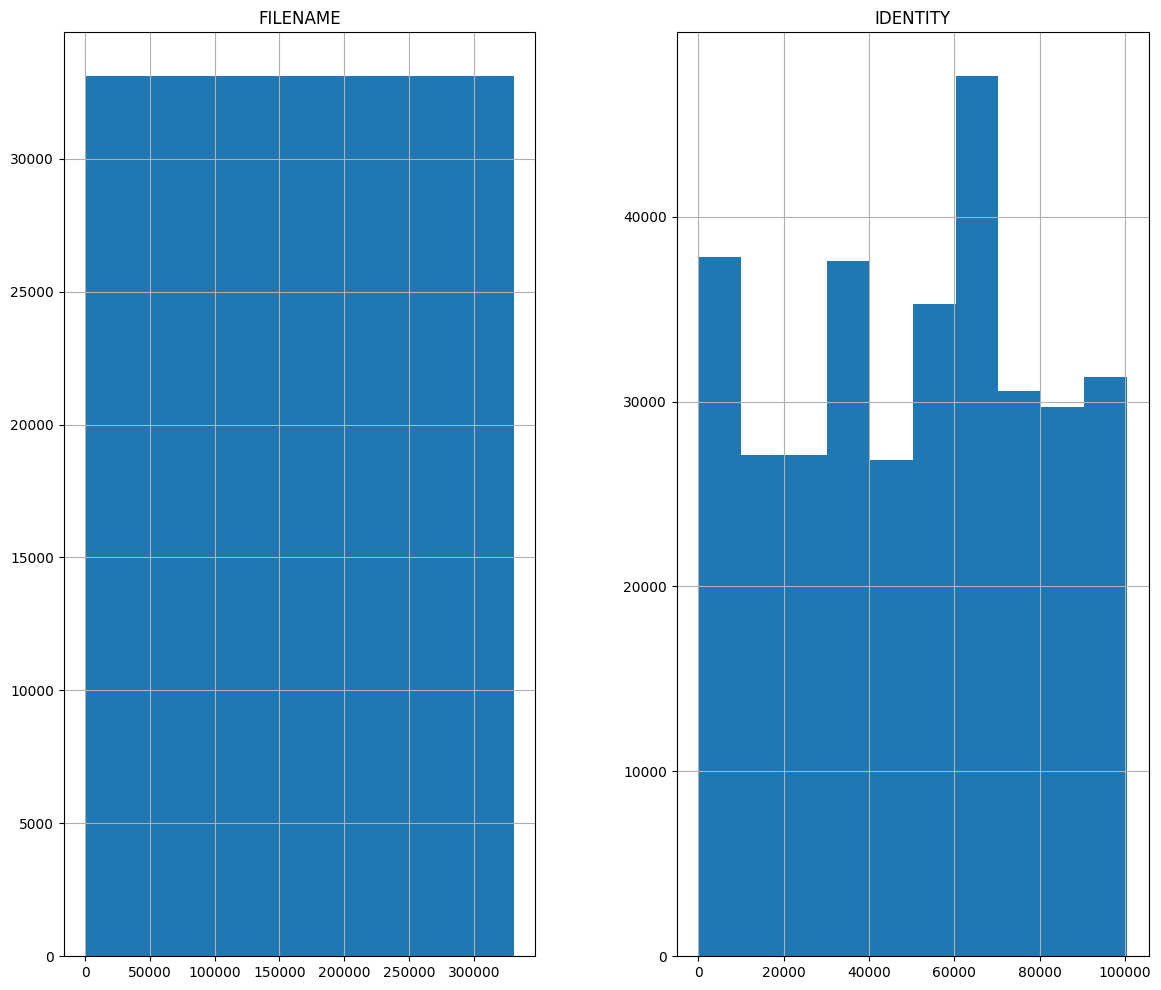

In [16]:
train1.hist(figsize=(14,12))
plt.show()

In [17]:
train1.corr()

,FILENAME,IDENTITY
FILENAME,1.000000,0.000332
IDENTITY,0.000332,1.000000


HEATMAP

<Axes: >

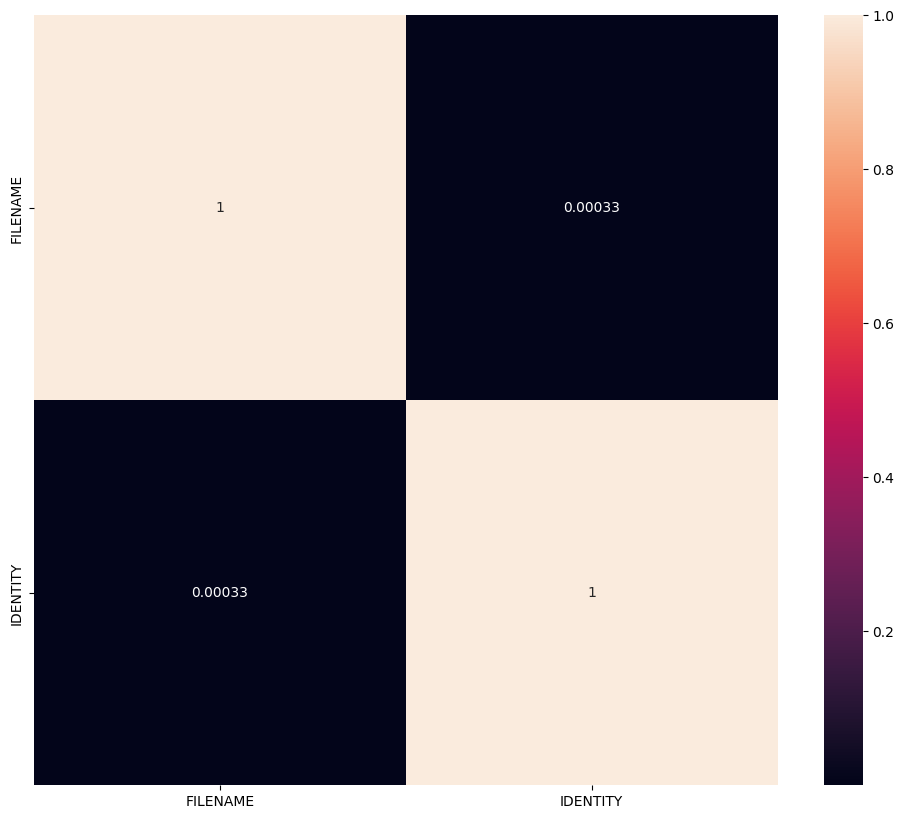

In [18]:
import seaborn as sns
plt.figure(figsize = (12,10))

sns.heatmap(train1.corr(), annot =True)

BOXPLOT

<Axes: xlabel='IDENTITY'>

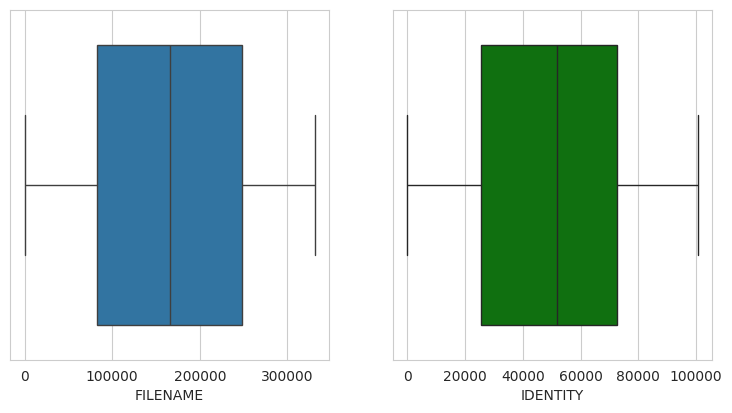

In [19]:
plt.figure(figsize=(14,10))
sns.set_style(style='whitegrid')
plt.subplot(2,3,1)
sns.boxplot(x='FILENAME',data=train1)
plt.subplot(2,3,2)
sns.boxplot(x='IDENTITY',data=train1,color='green')

BARPLOT

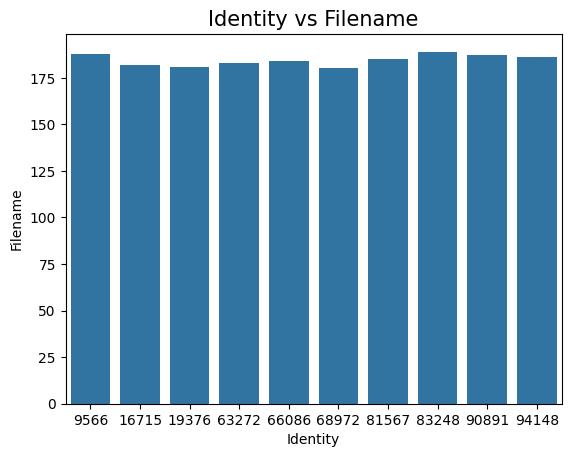

In [20]:
plt.style.use("default")
sns.barplot(x="IDENTITY", y="FILENAME",data=train1[180:190])
plt.title("Identity vs Filename",fontsize=15)
plt.xlabel("Identity")
plt.ylabel("Filename")
plt.show()

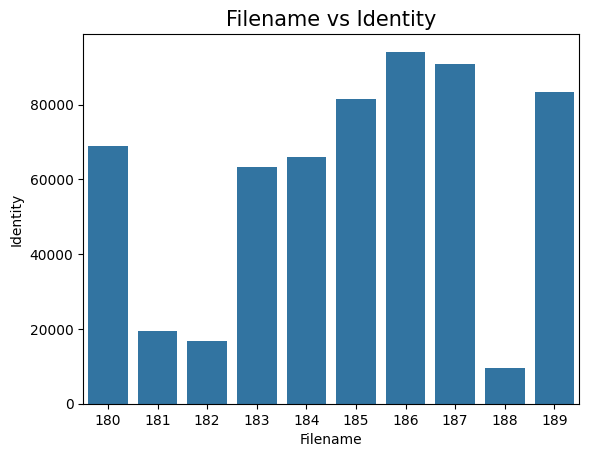

In [21]:
plt.style.use("default")
sns.barplot(x="FILENAME", y="IDENTITY",data=train1[180:190])
plt.title("Filename vs Identity",fontsize=15)
plt.xlabel("Filename")
plt.ylabel("Identity")
plt.show()

LINEPLOT

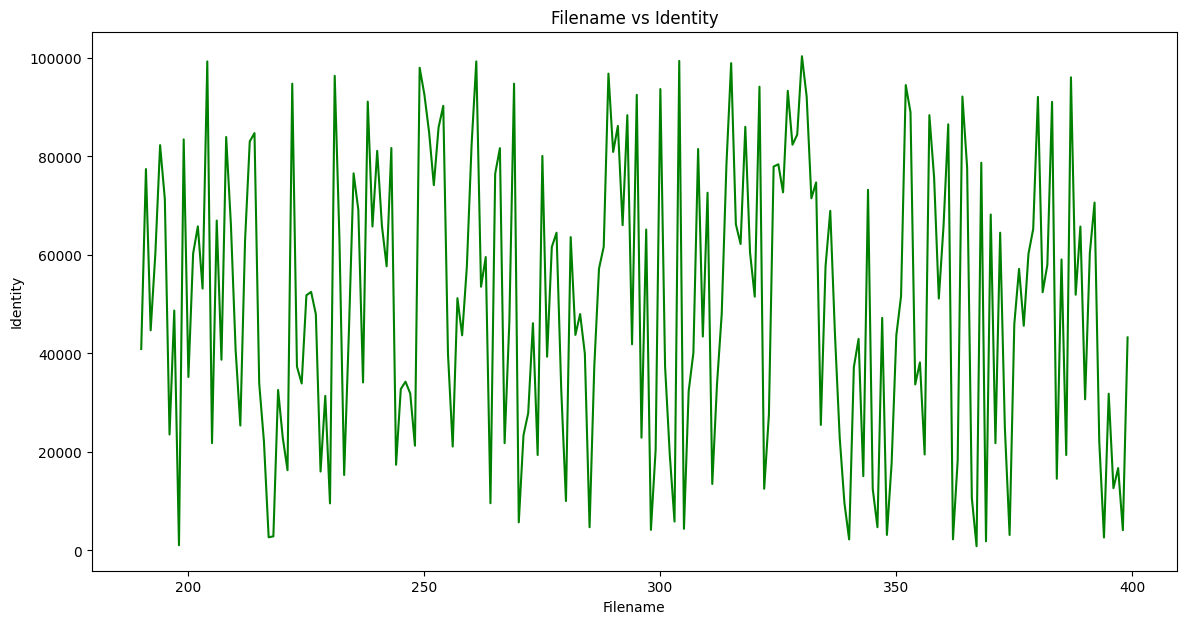

In [22]:
plt.style.use("default")
plt.figure(figsize=(14,7))
sns.lineplot(x = "FILENAME",y = "IDENTITY",data = train1[190:400], color='g')
plt.title("Filename vs Identity")
plt.xlabel("Filename")
plt.ylabel("Identity")
plt.show()

KDE PLOT

<ipython-input-23-e6414ac08211>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train1['IDENTITY'],shade=True,color='g')


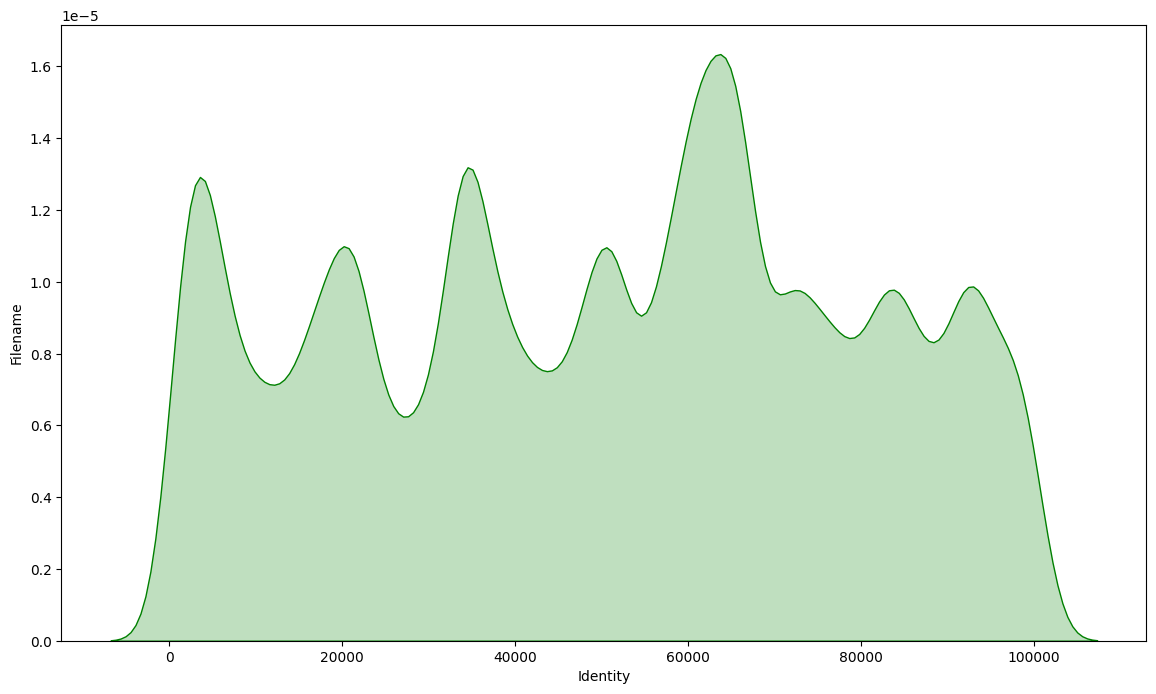

In [23]:
plt.style.use("default")
plt.figure(figsize=(14,8))
plt.xlabel('Identity')
plt.ylabel('Filename')
sns.kdeplot(train1['IDENTITY'],shade=True,color='g')
plt.show()

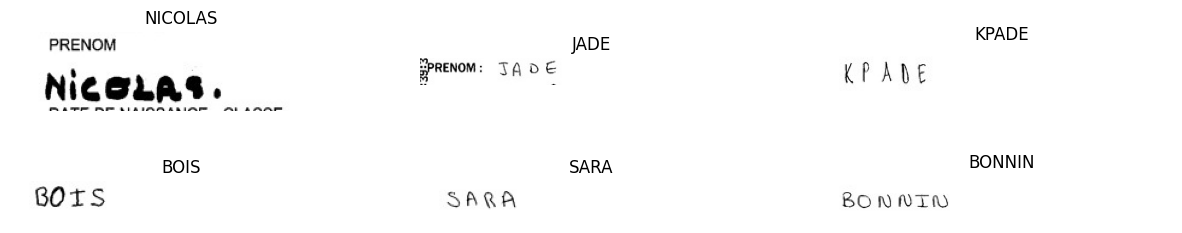

In [24]:
plt.figure(figsize=(15, 10))

# Check if train DataFrame is empty
if train.empty:
    print("Error: 'train' DataFrame is empty.")
else:
    # Iterate over the first 6 rows or until the end of the DataFrame, whichever comes first
    for i in range(min(6, len(train))):
        ax = plt.subplot(2, 3, i+1)

        # Construct the file path correctly
        img_filename = train.iloc[i, 0]  # Assuming first column contains filenames
        img_dir = os.path.join('/kaggle/input/handwriting-recognition/train_v2/train', img_filename)

        # Debugging: Check if the file exists
        if not os.path.exists(img_dir):
            print(f"Error: File {img_dir} does not exist.")
            continue

        image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)

        # Debugging: Check if the image was loaded correctly
        if image is None:
            print(f"Error: Unable to read image {img_dir}")
            continue

        plt.imshow(image, cmap='gray')
        plt.title(train.iloc[i, 1], fontsize=12)  # Assuming second column has titles
        plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)
plt.show()

## Cleaning Data

Let's check for NaNs in our label.

In [25]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  17
Number of NaNs in validation set :  3


In [26]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

Also, there are some images in our data with the label 'UNREADABLE'. Lets check those images and remove them.

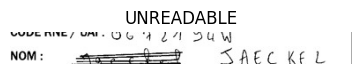

In [27]:
# Filter unreadable images
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace=True, drop=True)

plt.figure(figsize=(15, 10))

# Iterate over available rows in 'unreadable'
for i in range(unreadable.shape[0]):
    ax = plt.subplot(2, 3, i+1)

    # Construct the correct image path
    img_filename = unreadable.loc[i, 'FILENAME']
    img_dir = os.path.join('/kaggle/input/handwriting-recognition/train_v2/train', img_filename)

    # Debugging: Check if file exists
    if not os.path.exists(img_dir):
        print(f"Error: File {img_dir} does not exist.")
        continue  # Skip this iteration

    # Read the image
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)

    # Debugging: Check if image was read successfully
    if image is None:
        print(f"Error: Unable to read image {img_dir}")
        continue

    plt.imshow(image, cmap='gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)
plt.show()


In [28]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

There are some labels which are in lowercase. To maintain uniformity in the labels, I convert all the labels to uppercase.

In [29]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

Reset the index and we are done with cleaning.

In [30]:
train.reset_index(inplace = True, drop=True)
valid.reset_index(inplace = True, drop=True)

## Preprocessing and preparing the images for training

* The images are loaded as grayscale and reshaped to width 256 and height 64.  
* The width and height are cropped if they are greater than 256 and 64 respectively. If they are smaller, then the image is padded with white pixels. Finally the image is rotated clockwise to bring the image shape to (x, y).
* The image is then normalized to range [0, 1]

In [31]:
def preprocess(img):
    (h, w) = img.shape

    final_img = np.ones([64, 256])*255 # blank white image

    # crop
    if w > 256:
        img = img[:, :256]

    if h > 64:
        img = img[:64, :]


    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

The model will be trained on 30000 images and validate on 3000 images

In [32]:
train_size = 3000
valid_size= 300

In [ ]:
# train_x = []

# for i in range(train_size):
#     img_dir = '/kaggle/input/handwriting-recognition/train_v2/train'+train.loc[i, 'FILENAME']
#     image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
#     image = preprocess(image)
#     image = image/255.
#     train_x.append(image)

In [33]:
train_x = []

for i in range(train_size):
    img_dir = '/kaggle/input/handwriting-recognition/train_v2/train/' + train.loc[i, 'FILENAME'] # Added '/' to create the correct path
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)

    # Check if image loaded successfully
    if image is not None:
        image = preprocess(image)
        image = image/255.
        train_x.append(image)
    else:
        print(f"Warning: Could not load image at {img_dir}") # Print warning for failed image loads

In [ ]:
# valid_x = []

# for i in range(valid_size):
#     img_dir = '/kaggle/input/handwriting-recognition/validation_v2/validation'+valid.loc[i, 'FILENAME']
#     image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
#     image = preprocess(image)
#     image = image/255.
#     valid_x.append(image)

In [34]:
valid_x = []

for i in range(valid_size):
    img_dir = '/kaggle/input/handwriting-recognition/validation_v2/validation/' + valid.loc[i, 'FILENAME'] # Added '/' to fix the path
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)

    # Check if image loaded successfully
    if image is not None:
        image = preprocess(image)
        image = image/255.
        valid_x.append(image)
    else:
        print(f"Warning: Could not load image at {img_dir}") # Print a warning for failed image loads

In [35]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

## Preparing the labels for CTC Loss

Learn more about CTC loss and why its amazing for text recognition from [here](https://theailearner.com/2019/05/29/connectionist-temporal-classificationctc/).

The labels have to be converted to numbers which represent each character in the training set. The 'alphabets' consist of A-Z and three special characters (-  '  and space).

In [36]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))

    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [37]:
name = 'JEBASTIN'
print(name, '\n',label_to_num(name))

JEBASTIN 
 [ 9  4  1  0 18 19  8 13]


DIVIDING THE DATA SET

In [38]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    # Convert the 'IDENTITY' value to a string before calculating its length
    train_label_len[i] = len(str(train.loc[i, 'IDENTITY']))
    train_y[i, 0:len(str(train.loc[i, 'IDENTITY']))]= label_to_num(str(train.loc[i, 'IDENTITY']))

In [39]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    # Convert the 'IDENTITY' value to a string before calculating its length
    valid_label_len[i] = len(str(valid.loc[i, 'IDENTITY']))
    valid_y[i, 0:len(str(valid.loc[i, 'IDENTITY']))]= label_to_num(str(valid.loc[i, 'IDENTITY']))

In [40]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100],
      '\ntrain_input_len : ', train_input_len[100])

True label :  JULIEN 
train_y :  [ 9. 20. 11.  8.  4. 13. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [6.] 
train_input_len :  [62.]


## Building our model


In [41]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 256, 64, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 256, 64, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 64, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max1 (MaxPooling2D)             │ (None, 128, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 128, 32, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 32, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2 (MaxPooling2D)             │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 64, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max3 (MaxPooling2D)             │ (None, 64, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64, 64)         │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm1 (Bidirectional)           │ (None, 64, 512)        │       657,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm2 (Bidirectional)           │ (None, 64, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 64, 30)         │        15,390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 64, 30)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,406,878 (9.18 MB)

 Trainable params: 2,406,430 (9.18 MB)

 Non-trainable params: 448 (1.75 KB)

The output shape of the predictions is (64, 30). The model predicts words of 64 characters and each character contains the probability of the 30 alphabets which we defined earlier.  

In [42]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [43]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

## Train our model

In [63]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate = 0.0001))

history=model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output,
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=120, batch_size=128)

Epoch 1/120
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 313ms/step - loss: 0.3670 - val_loss: 6.2919
Epoch 2/120
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 261ms/step - loss: 0.3680 - val_loss: 6.3038
Epoch 3/120
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 262ms/step - loss: 0.3181 - val_loss: 6.2706
Epoch 4/120
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 272ms/step - loss: 0.3222 - val_loss: 6.2305
Epoch 5/120
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 275ms/step - loss: 0.3147 - val_loss: 6.3155
Epoch 6/120
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - loss: 0.2863 - val_loss: 6.3277
Epoch 7/120
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step - loss: 0.3011 - val_loss: 6.3419
Epoch 8/120
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 267ms/step - loss: 0.3213 - val_loss: 6.5061
Epoch 9/120
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 257ms/step - loss: 0.3297 - val_loss: 6.2850
Epoch 10/120
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 257ms/step - loss: 0.3464 - val_loss: 6.3075
Epoch 11/120
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - loss: 0.3339 - val_loss: 6.2639
Epoch 12/120
24/24 ━━━━━━━━━━━━━━━━

PLOTING THE TRAINING LOSS AND VALIDATION LOSS

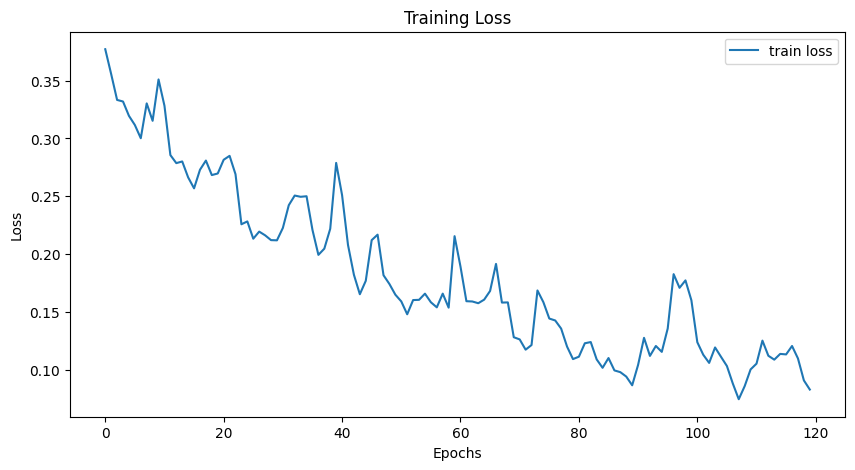

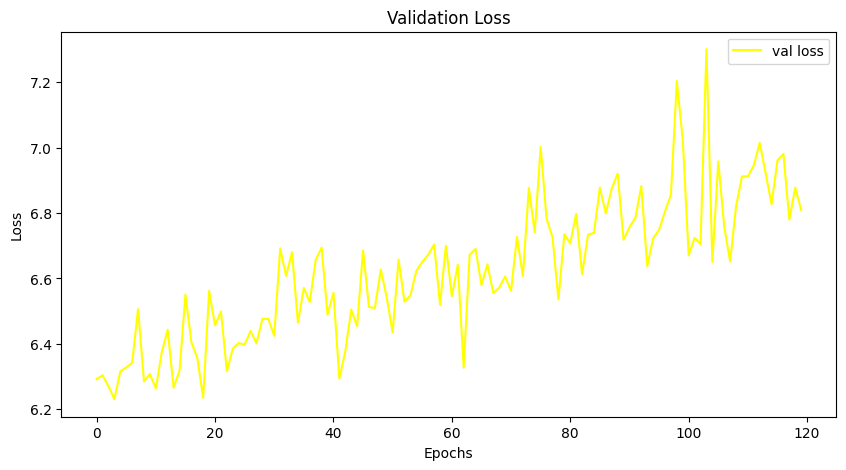

In [64]:
# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()
# Plot the validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['val_loss'], label='val loss',color='yellow')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss')
plt.show()

In [65]:
model.save('handwriting_recognition_model.h5')  # HDF5 format

## Check model performance on validation set

In [66]:
model.save('handwriting_recognition_model.keras')  # New Keras v3 format

In [67]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1],
                                   greedy=True)[0][0])

prediction = []

for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [68]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)

    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1

    if pr == tr :
        correct += 1

print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 64.53%
Correct words predicted      : 35.00%


## Some predictions on test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


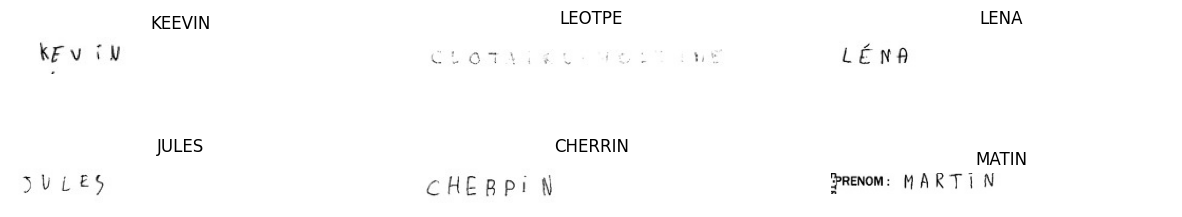

In [69]:
test = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    # The original path was incorrect. Add '/' to create a valid path
    img_dir = '/kaggle/input/handwriting-recognition/test_v2/test/' + test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)

    # Check if the image was loaded successfully
    if image is not None:
        plt.imshow(image, cmap='gray')

        image = preprocess(image)
        image = image/255.
        pred = model.predict(image.reshape(1, 256, 64, 1))
        decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1],
                                           greedy=True)[0][0])
        plt.title(num_to_label(decoded[0]), fontsize=12)
        plt.axis('off')
    else:
        print(f"Warning: Could not load image at {img_dir}")  # Print a warning if image loading fails

plt.subplots_adjust(wspace=0.2, hspace=-0.8)